# [IR] Project - Topics 1, 3 and 4

Kacper Trębacz [145453]

Jan Gruszczyński [145464]

In [79]:
import pandas as pd
import seaborn as sbn
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse.linalg import norm
from matplotlib.colors import LogNorm, Normalize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import cosine
from scipy import sparse

from bs4 import BeautifulSoup
from pathlib import Path
import multiprocessing as mp
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
import re

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Janek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Utils:

In [2]:
# This function may be used to process some tasks in parallel.
# Warning seems not to work on Windows!!!

def do_parallel(func, data):
    pool = mp.Pool(mp.cpu_count()-4)
    result = pool.starmap(func,data)
    pool.terminate()
    return result

# Part 1: Crawling and scraping

We have used scraper implemented in JavaScript (NodeJs), as it seemed the most efficient method. The code lies in the folder "./crawler". There are two version of it, singiel thread and multi-thread version. Scrapper works in the following way: It starts at a specific page of wikipedia, while downloading the content of the pages, it adds all the wikipedia links to a queue. After the content is downloaded, the next page (or many in the case of multi-thread version) from the queue are processed in a continuous loop. Content and titles of the pages are saved in "./crawler/pages" folder in the form of raw html.


#### To show that our predictions make sens, we scraped very different parts of wikipedia. For example the crawler scraped sites around Star Wars, Elon Musk, Potatoes, etc.

# Part 2: Stemming, lemmatization

In [4]:
pages_path = Path("./crawler/pages/")

Firstly we do some basic preprocessing, remove content of navbars, non essential texts in articles, extract texts and title of articles into python lists.

In [6]:
def extract_text_title(path):
    title = path.stem
    
    # Banned titles
    for banned in ["User:", "MOS:", "Portal:", "File:", "Help:", "Talk", "Special:", "Template:", "Category:", "Wikipedia:", "User_talk:", "Template_talk:", "Wikipedia_talk:", ]:
        if title.startswith(banned):
            return None
    
    # Extracting content from htmls
    soup = BeautifulSoup(path.read_text(encoding="utf8"))
    for mth in soup.find_all("span", {'class':'mwe-math-element'}): 
        mth.decompose()
    texts = []
    # Here we extracted headlines, but usually they contain the same words, so they have no impact on prediction.
    #Lets skip headlines, because their words will apper in text anyway 
    #
#     for hi in [1,2,3,4]:# order is not important in tfidf
#         for el in soup.find_all(f"h{hi}"):
#             text = el.get_text()
#             if text.lower().endswith("[edit]"):
#                 text=text[:-6]
#             texts.append(text)
    for p in soup.select("#bodyContent > #mw-content-text > div.mw-parser-output > p"):
        texts.append(p.get_text())
    return (title,"\n".join(texts))

In [7]:
paths  = list(pages_path.iterdir())

# Parallel version:
# titles_texts = do_parallel(extract_text_title,[(path,) for path in pages_path.iterdir()])
# titles_texts = [tt for tt in titles_texts if tt != None]

titles_texts = [extract_text_title(path) for path in paths]
titles_texts = [tt for tt in titles_texts if tt != None and not tt[0].find("%") != -1] # Some errors in names
titles = [title for title, text in titles_texts]
#print(titles)

Saving raw texts

In [8]:
texts_path = Path("./texts")

In [10]:
texts_path.mkdir(exist_ok=True)

In [11]:
def save_document_text(title,text):
    path = Path(f"./texts/{title}.txt")
    path.write_text(text, encoding="utf8")

In [13]:
# Parallel version:
# _ = do_parallel(save_document_text,[(title,text) for title,text in titles_texts])

_ = [save_document_text(title, text) for title, text in titles_texts]

In [14]:
texts_path = Path("./texts")
# N = to the number of processed websites. 
N = 1000

In [15]:
def read_document(path):
    return (path.stem,path.read_text(encoding="utf8"))

In [16]:
# Parallel version:
# titles_texts = do_parallel(read_dcoument,[(path,) for path in texts_path.iterdir()][:N])

titles_texts  = [read_document(path) for path in list(texts_path.iterdir())[:N]]

Now we would like to clean texts of the article before we tokenize them.

In [20]:
titles = [t[0] for t in titles_texts]
texts = [t[1] for t in titles_texts]
print(texts[74])



In the APG IV system (2016) for the classification of flowering plants, the name asterids denotes a clade (a monophyletic group). Asterids is the largest group of flowering plant with more than 80,000 species, about a third of the total flowering plant species[1].[2] Well known plants in this clade include the common daisy, forget-me-nots, nightshades (including potatoes, eggplants, tomatoes, peppers and tobacco), the common sunflower, petunias, yacon, morning glory, sweet potato, coffee, lavender, lilac, olive, jasmine, honeysuckle, ash tree, teak, snapdragon, sesame, psyllium, garden sage, table herbs such as mint, basil, and rosemary, and rainforest trees such as Brazil nut.

Most of the taxa belonging to this clade had been referred to the Asteridae in the Cronquist system (1981) and to the Sympetalae in earlier systems.[citation needed]  The name asterids (not necessarily capitalised) resembles the earlier botanical name but is intended to be the name of a clade rather than a fo

In [21]:
texts  = [re.sub('\s+', ' ', text) for text in texts] # Replaces all whitespaces and all white signs with a singiel space
texts  = [re.sub('[^a-zA-Z -]+', '', text) for text in texts] # Leaves only letters from a lating alphabet 
print(texts[74])

 In the APG IV system  for the classification of flowering plants the name asterids denotes a clade a monophyletic group Asterids is the largest group of flowering plant with more than  species about a third of the total flowering plant species Well known plants in this clade include the common daisy forget-me-nots nightshades including potatoes eggplants tomatoes peppers and tobacco the common sunflower petunias yacon morning glory sweet potato coffee lavender lilac olive jasmine honeysuckle ash tree teak snapdragon sesame psyllium garden sage table herbs such as mint basil and rosemary and rainforest trees such as Brazil nut Most of the taxa belonging to this clade had been referred to the Asteridae in the Cronquist system  and to the Sympetalae in earlier systemscitation needed The name asterids not necessarily capitalised resembles the earlier botanical name but is intended to be the name of a clade rather than a formal ranked name in the sense of the ICBN Genetic analysis carried 

In [22]:
porter = PorterStemmer()
# lancaster = LancasterStemmer()
wordnet = WordNetLemmatizer()

In [23]:
stop_words = set(stopwords.words('english'))

In [24]:
def stem_lem(text):
    tokenized_words = word_tokenize(text)
    words = [porter.stem(wordnet.lemmatize(word)) for word in tokenized_words] # Tokenizing and lemmatizing 
    words = [word for word in words if word not in stop_words] # Removing stop words
    return " ".join(words)

In [25]:
# Parallel version:
# stemmed_lemmed = do_parallel(stem_lem,[(text,) for text in texts])

stemmed_lemmed = [stem_lem(text) for text in texts]

Final pages containg lemmed, stemmed words, ready for calculation.

In [26]:
print(stemmed_lemmed[0])

pl internet countri code top-level domain cctld poland administ nask polish research develop organ one found member centr pl domain wa creat follow mitig cocom embargo technolog collabor post-communist countri first subdomain pl wa pwrpl belong wrocaw univers technolog number regist pl domain name exceed one million wherea end registri compris million domain name domain must regist nation domain name registri sever function region domain end exist popular region domain end pl zone


Interesting statistics about our dataset:

In [27]:
# Most common words:
def count_word_occurences(texts, N=10):
    word_occurences = {}
    for text in texts:
        for word in text.split():
            try:
                word_occurences[word] += 1
            except KeyError:
                word_occurences[word] = 1
    word_occurences = dict(sorted(word_occurences.items(), key=lambda item: item[1], reverse=True))
    word_occurences = list(word_occurences.items())
    word_occurences = dict(word_occurences[:N])
    return word_occurences

print(count_word_occurences(stemmed_lemmed))

{'wa': 19186, 'use': 10537, 'thi': 9535, 'also': 8115, 'ha': 7893, 'includ': 6935, 'one': 5900, 'first': 5870, 'hi': 5546, 'new': 5458}


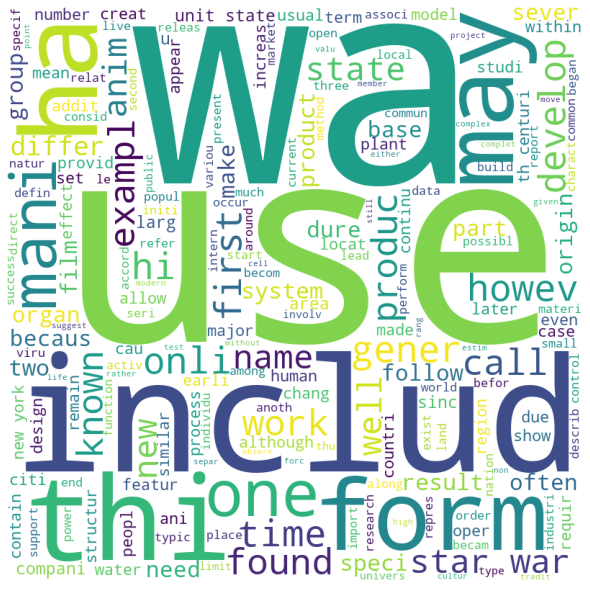

In [28]:
# To show word occurences is a bit more accesible way we decided to created word cloud presented below.
texts_for_wordcloud = ' '.join(stemmed_lemmed)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(texts_for_wordcloud)       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

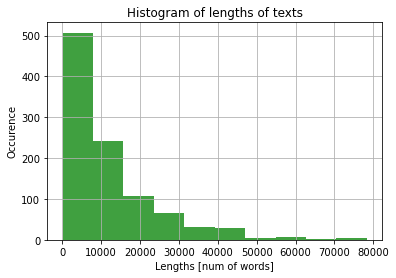

In [29]:
# Here we create a histogram for lengths of articles texts
lengths = [len(text) for text in stemmed_lemmed]
n, bins, patches = plt.hist(lengths, facecolor='g', alpha=0.75)
plt.xlabel('Lengths [num of words]')
plt.ylabel('Occurence')
plt.title('Histogram of lengths of texts')
plt.grid(True)
plt.show()

# Part 3: Calculation of Similarities

To calculate the similarities between articles, we create a TF-IDF (term frequency-inverse document frequency) matrix, so that each document is represented as a vector of TF-IDF weigths. Then to compare the documents we just need to calculate the cosine similarity.

In [32]:
tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False) 
tfidf_matrix = tfidf.fit_transform(stemmed_lemmed)
dfTFIDF = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, index=titles, columns=tfidf.get_feature_names_out())

# Here is the matrix described above.
dfTFIDF

,aa,aaa,aaai,aabar,aabco,aabsin,aac,aachen,aahc,aak,...,zygomycota,zygos,zygot,zymas,zymou,zynga,zypper,zyryanka,zyzak,zz
.pl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360_Architecture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abrasion_(mechanical),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abrasive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Academy_Awards,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Theropoda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Book_of_Boba_Fett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Boring_Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Empire_Strikes_Back,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# Saving our data to .csv file
# dfTFIDF.to_csv("dfTFIDF.csv", encoding='utf-8', index=False)
# Please note it takes very long and the matrix takes a lot of memory.

#The sparse matrix can also save efficiently in the form of a sparse matrix.
with open('test.pkl','wb') as f:
     pickle.dump(tfidf_matrix, f)

with open('test.pkl','rb') as f:
    tfidf_matrix = pickle.load(f)
dfTFIDF = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, index=titles, columns=tfidf.get_feature_names_out())

Here we calculate cosine similarity of small subset of documents and show it in the form of a heatmap. As we can see values on the diagonal are equal to one, meaning that articles compared to themselves have cosine similarity of one, meaning they are the same according to this method. This heatmap may also help to visualize results of the matrix. 

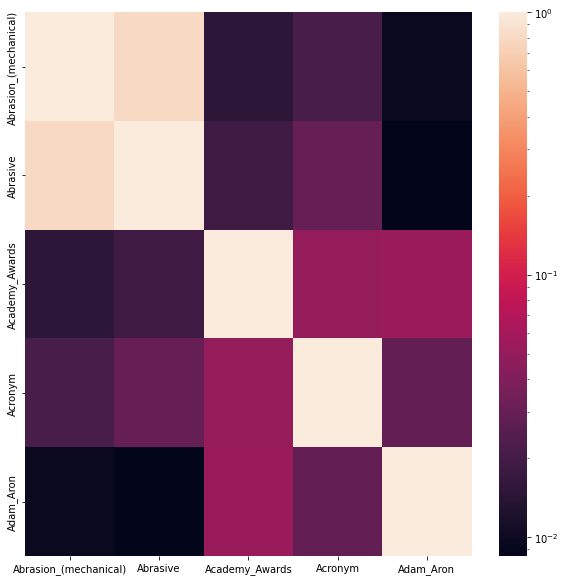

In [33]:
def heatmap_of_similarities(tfidf_matrix,titles, n1, n2):
    similarity_matrix = cosine_similarity(tfidf_matrix[n1:n2], tfidf_matrix[n1:n2])
    fig, heatmap_ax = plt.subplots(figsize=(10, 10))
    sbn.heatmap(similarity_matrix, norm=LogNorm(), ax=heatmap_ax, xticklabels=titles[n1:n2], yticklabels=titles[n1:n2])
    plt.show()
heatmap_of_similarities(dfTFIDF, titles, 2, 7)

Liczmy similiarty kazdej strony ze histori ze wszystkim w datasecie. dostajemy tutaj 3 vektory, i kolejno dzielimy przez e^0, e^-1/4, e i te vektoruy dodajemy do siebie i wybieramy n najlepszych

The final predictions are obtained in the following way: 

For every page visited by the user we calculate it similarity to every other page in the dataset. In that way we get N (where N is the number of visited pages) vectors of cosine similarities. Then the corresponding vectors are multiplied by weights coresponding to consequtive powers of e^-(i/4), where i is from 0 to N-1, so that each following (visted earlier) page has a smaller effect on final prediction. Then we sum the vectors, sort obtained values, and get the prediciton.

In [35]:
def get_similarities(previous_titles):
    if not all(t in titles for t in previous_titles):
        raise BaseException("Title not found in matrix")
    similarities = []
    idxs = np.array([titles.index(title) for title in previous_titles])
    for i in idxs:
        cos_sim = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
        cos_sim[idxs] = 0
        similarities.append(cos_sim)
    return np.array(similarities)

In [36]:
def get_weights(n):
    return np.exp(-np.array([(i)/4 for i in range(n)])) # order matters 

In [38]:
# Example of vector obtained from get_weights function
get_weights(5)

array([1.        , 0.77880078, 0.60653066, 0.47236655, 0.36787944])

In [39]:
def get_score(previous_titles):
    similarities = get_similarities(previous_titles)
    weights = get_weights(len(previous_titles))
    weights = weights/np.sum(weights)
    return np.sum(similarities.T*weights, axis=1)

In [40]:
def get_predictions(previous_titles,n = 5):
    scores = get_score(previous_titles)
    return [titles[i] for i in scores.argsort()[-n:][::-1]]

In [77]:
titles[75:85]

['Atoll',
 'Attested_language',
 'Audiovisual',
 'Autoencoder',
 'Automated_machine_learning',
 'Autonomous_spaceport_drone_ship',
 'Avemetatarsalia',
 'Avestan',
 'Bachelor_of_Arts',
 'Bachelor_of_Science']

Let's test our prediction algorithm. The dataset is diverse, let's check it will manage to propose related articles.

In [42]:
history = ['Star_Wars', 'Star_Wars_prequel_trilogy', 'Star_Wars_Trilogy' ]
predictions = get_predictions(history,10)
predictions

['List_of_Star_Wars_films#Produced_for_television',
 'List_of_Star_Wars_films#Academy_Awards',
 'Skywalker_saga',
 'List_of_Star_Wars_films',
 'List_of_Star_Wars_films#Skywalker_Saga',
 'List_of_Star_Wars_films#Rogue_Squadron_(TBA)',
 'List_of_Star_Wars_films#Anthology_films',
 'Star_Wars_expanded_to_other_media',
 'Star_Wars_sequel_trilogy',
 'Star_Wars_(film)']

In [45]:
history = ['Elon_Musk', 'SpaceX_Dragon', 'SpaceX_Starship']
predictions = get_predictions(history,10)
predictions

['SpaceX',
 'Falcon_9',
 'Elon_Musk_in_popular_culture',
 'Commercial_Resupply_Services',
 'List_of_awards_and_honors_received_by_Elon_Musk',
 'Falcon_1',
 'Kimbal_Musk',
 'NASA',
 'Commercial_Orbital_Transportation_Services',
 'Spaceflight']

In [46]:
# Let's test a harder query
history = ['Elon_Musk', 'Potato', 'Dinosaur']
predictions = get_predictions(history,10)
predictions

['Elon_Musk_in_popular_culture',
 'List_of_awards_and_honors_received_by_Elon_Musk',
 'Evolution_of_dinosaurs',
 'Kimbal_Musk',
 'Criticism_of_Tesla,_Inc.',
 'Maye_Musk',
 'Dinosaur_renaissance',
 'Potato_(disambiguation)',
 'Sweet_potato',
 'Tesla,_Inc.']

In [48]:
history = ['Elon_Musk', 'SpaceX_Dragon', 'SpaceX_Starship', 'Star_Wars']
predictions = get_predictions(history,10)
predictions

['SpaceX',
 'Elon_Musk_in_popular_culture',
 'Falcon_9',
 'List_of_awards_and_honors_received_by_Elon_Musk',
 'Star_Wars_expanded_to_other_media',
 'List_of_Star_Wars_films#Anthology_films',
 'List_of_Star_Wars_films#Rogue_Squadron_(TBA)',
 'List_of_Star_Wars_films',
 'List_of_Star_Wars_films#Academy_Awards',
 'Skywalker_saga']

In [50]:
#As we can see order of visited pages playes a role in prediciton.
history = ['Elon_Musk', 'Star_Wars', 'SpaceX_Dragon', 'SpaceX_Starship']
predictions = get_predictions(history,10)
predictions

['SpaceX',
 'Elon_Musk_in_popular_culture',
 'Falcon_9',
 'List_of_awards_and_honors_received_by_Elon_Musk',
 'Star_Wars_expanded_to_other_media',
 'List_of_Star_Wars_films#Anthology_films',
 'List_of_Star_Wars_films#Rogue_Squadron_(TBA)',
 'List_of_Star_Wars_films',
 'List_of_Star_Wars_films#Academy_Awards',
 'Skywalker_saga']

In [66]:
history = ['Potato', 'Sweet_potato', 'Potato_chip']
predictions = get_predictions(history,10)

Here we plot the similarities between user history and our predictions. 

As we can see, the earlier the page was visited by user the smaller effect it has on our prediction. 

Also the quality of prediction degrades the further we go in the list of predicted interesting documents. This can be seen as coresponding rows get darker the further we are on x-axis.

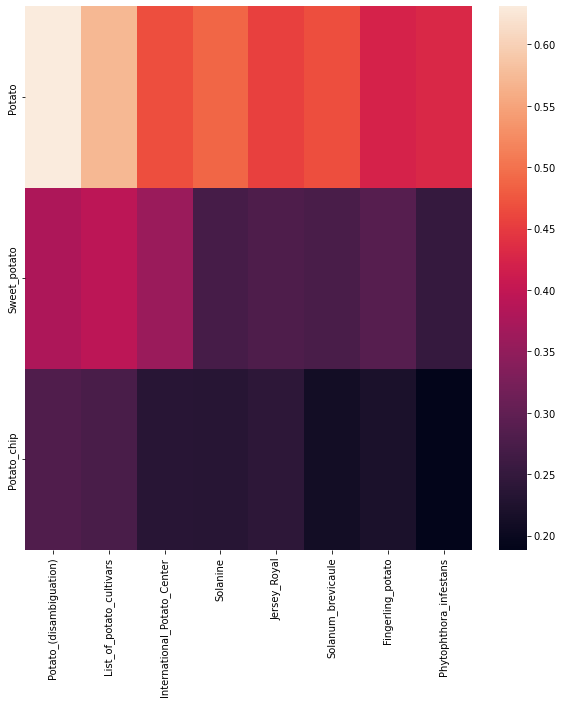

In [67]:
def final_heatmap(history, predictions):
    history_indexes = np.array([titles.index(title) for title in history])
    predictions_indexes  = np.array([titles.index(title) for title in predictions])
    similarity_matrix = cosine_similarity(tfidf_matrix[history_indexes], tfidf_matrix[predictions_indexes[:-2]])
    fig, heatmap_ax = plt.subplots(figsize=(10, 10))
    np_titles = np.array(titles)
    sbn.heatmap(similarity_matrix, ax=heatmap_ax, 
                xticklabels=np_titles[predictions_indexes[:-2]], yticklabels=np_titles[history_indexes])
    plt.show()
final_heatmap(history, predictions)

Here we try to explain each prediction in a more detailed way:

We try to find which words had the biggest impact on each prediction. To do that, we multiple corresponding rows of tfidf matrix and divide them by norm(tfidf_matrix[ihist])*norm(tfidf_matrix[ipred]), and then we multiply it by obtained weights. 

In a result, we obtain scores for words describing somewhat their power in prediction making.


score(word,predicted,history) = (predicted[word]\*history[word])/sqrt(l2(history)*l2(predicted))

For each predicted article we plot a bar plot showing the impact of most impactful 10 words from each article from history. So sorry for the confusing language.

In [74]:
def explain(history, predictions):
    explanations = []
    weights = get_weights(len(history))
    for pred in predictions:
        ipred = titles.index(pred)
        explanation = []
        for w, hist in enumerate(history):
            ihist = titles.index(hist)
            mask = tfidf_matrix[ipred].multiply(tfidf_matrix[ihist]).toarray()[0] 
            mask /= (norm(tfidf_matrix[ihist])*norm(tfidf_matrix[ipred]))**0.5#not necesseary because values in have length 1
            mask *= weights[w]
            top_word_indices = mask.argsort()[-10:]
            top_word_ind_similarities = [(dfTFIDF.columns[idx], mask[idx]) for idx in top_word_indices]
            explanation.append(top_word_ind_similarities)
        explanations.append(explanation)
    return explanations

explanations = explain(history, predictions)

In [75]:
plt.rcParams['figure.figsize'] = [16, 9]

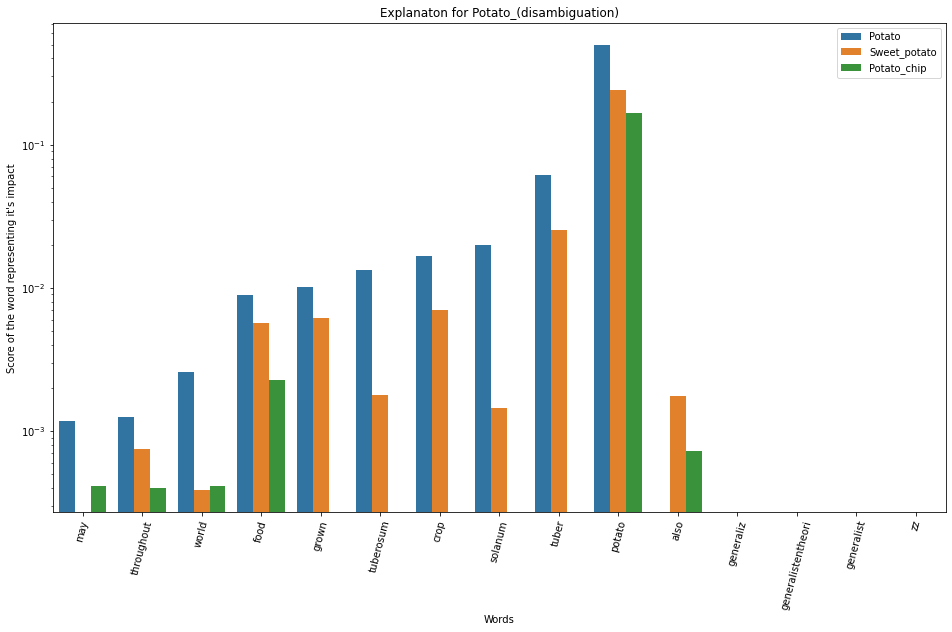

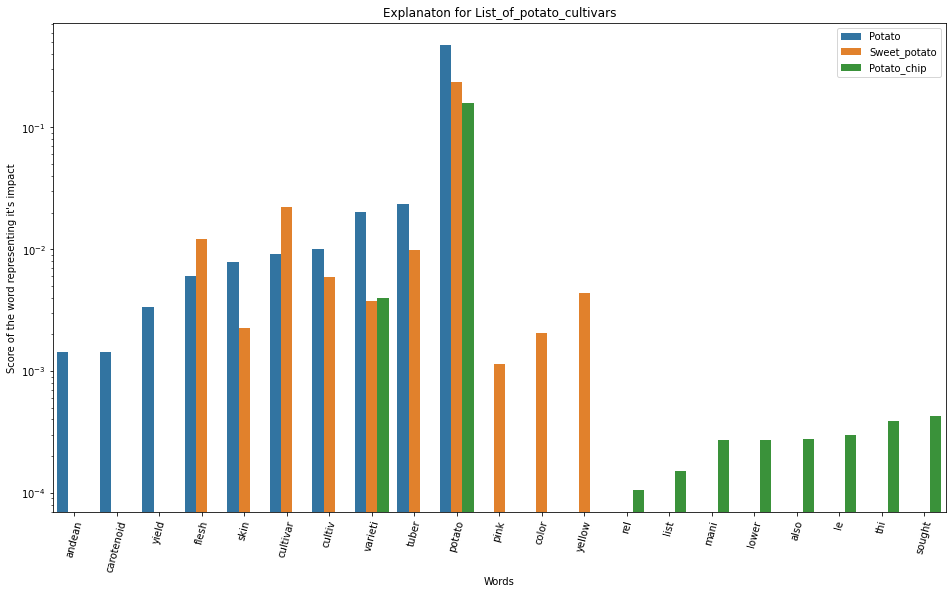

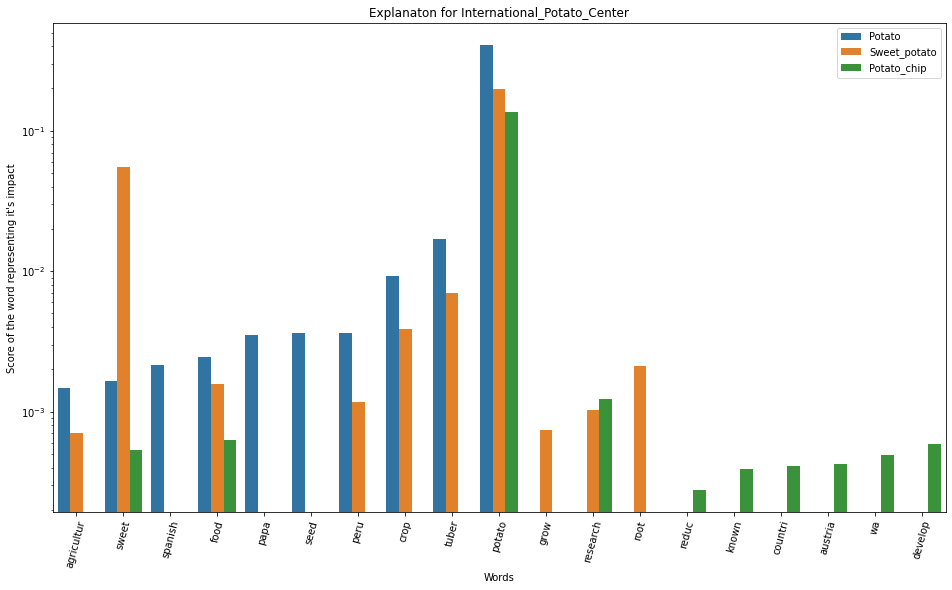

In [76]:
def plot_explanation(explanation, history, current_recomendation, do_log = False):
    all_words = []
    for hist in explanation:
        all_words.extend([word for word, number in hist])
        
    df = pd.DataFrame({
        'Words': all_words
    })
    
    for i, hist in enumerate(explanation):
        current_words_dict  = dict(hist)
        current_words = list(current_words_dict.keys())
        values = []
        for word in all_words:
            if word in current_words:
                values.append(current_words_dict[word])
            else:
                values.append(0)
        df[history[i]] = values
    
    fig, ax1 = plt.subplots() #plt.subplots(figsize=(10, 10))
    tidy = df.melt(id_vars='Words').rename(columns=str.title)
    sbn.barplot(x='Words', y='Value', hue='Variable', data=tidy, ax=ax1)

    plt.title(f"Explanaton for {current_recomendation}")
    if do_log:
        plt.yscale("log")
    plt.legend()
    plt.ylabel("Score of the word representing it's impact")
    plt.xticks(rotation=75)
    plt.show()

counter = 0 
# Plotting explanation for first three predictions:
for explenation in explanations[:3]:
    plot_explanation(explenation, history, predictions[counter], True)
    counter += 1

As we can see, usually words from the most recently visited post have the biggest impact. As it might have been guessed, for this query potato plays the biggest role. It should be noted, from time to time the impact of a word may be equal to slim to none.

Thank you for reading our raport. 